## Clay Sciences video annotation demo notebook
#### v0.1, Nov 8 2018

### Requirements: 
* Have all the python packaged imported below
* Extract all frames of the video to folder FRAMES_DIR (video=https://claysc-cors.s3.amazonaws.com/videos/time_square_short.mp4)
* The file images.zip on github contains the extracted frames
* For the second part, have fastai 1 installed and configured to use a GPU. See  https://github.com/fastai/fastai/tree/master/old
* To launch an AWS instance configured for fastai, see https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md

### Note: the CNN model used in the second part of this notebook is overly simplified and does not achieve good results. Stay tuned for next version which will have a more robust model 
The main goal of this notebook is to show how fast you can get from video annotation to deep learning. An improved deep learning model will be updated here soon.

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import json
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
import random
from pathlib import Path
from collections import defaultdict

In [2]:
BASE_DIR = Path('data/new')
FRAMES_DIR = Path('data/new')
images = list(FRAMES_DIR.glob("*.jpg"))
# how are images named? change this if it doesn't match your files
ftemplate = "file%03d" 
print("Found {} images".format(len(images)))
if len(images) == 0:
    print("ERROR it seems you do not have the image relevant images at", FRAMES_DIR)

Found 240 images


## Helper methods

In [3]:
colors = ['white', 'cyan', 'red', 'orange']

def cs_draw_idx(i, figsize=(8,8), ax=None):
    """
    Plot image i in the given axis
    """
    stem = stem_ids[i]
    img = stem_dict[stem]
    boxes = []
    for obj_id in labels_dict[stem]:
        obj = labels_dict[stem][obj_id]
        xywh = get_wh(obj)
        im_a = (obj[0], xywh)
        boxes.append(im_a)
    im = Image.open(img)
    cs_draw_im(im, boxes, figsize=figsize, ax=ax)
    
def cs_draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def cs_draw_rect(ax, b, edgecolor='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=1))
    cs_draw_outline(patch, 2)
    
def cs_draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    cs_draw_outline(text, 2)

def cs_show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax    

def cs_draw_im(im, ann, figsize=(16,8), ax=None):
    sz = figsize[0] if figsize else 10
    sz = min(16, max(sz, 8))
    ax = cs_show_img(im, figsize=figsize, ax=ax)
    skip_labels = False
    i = 0   
    for b in ann:
        edgecolor = colors[i % len(colors)]
        i += 1
        coords = b[1]
        lable = b[0]
        cs_draw_rect(ax, coords, edgecolor=edgecolor)
        if not(skip_labels):
            cs_draw_text(ax, coords[:2]+[1,1], lable, sz=sz)


def get_wh(coords, from_size=None, to_size=None):
    """ get x,y,w,h from raw annotations. If both from_size and to_size are provided, resize"""
    ratio = [1.0, 1.0]
    if from_size and to_size:
        ratio = [t / f for t, f in zip(to_size, from_size)]
    [x,y,w,h] = [
        ratio[0]*float(coords[1]),
        ratio[1]*float(coords[2]),
        ratio[0]*float(coords[3]),
        ratio[1]*float(coords[4])
    ]
    [x,y,w,h] = [round(xx) for xx in [x,y,w,h]]
    return np.array([x,y,w,h])

def get_bb_yx_as_str(coords):
    [x1,y1,x2,y2] = wh_2bb(coords)
    yxbb = [y1,x1,y2,x2]
    return " ".join([str(o) for o in yxbb])

def wh_2bb(bb): return np.array([bb[0],bb[1], bb[2]+bb[0]-1, bb[3]+bb[1]-1])

def bb_2wh(a): return np.array([a[0], a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def yxbb_2wh(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


## Part I : Data Exploration

In [49]:
# json annotation file downloaded from Clay Sciences
data_file="data/new/Demo TS-November-08-2018.json" 

# we will limit ourselves to a single object tracking in this demo
first_obj_id = '0' # this is the id of the object we're going to train on

In [50]:
json_data=open(data_file).read()
data = json.loads(json_data)
# review one frame
print (json.dumps(data[10:11], indent=2))

[
  {
    "ID": "223_0.1_1_10",
    "Labeled Data": "https://claysc-cors.s3.amazonaws.com/videos/time_square_short.mp4",
    "Frame": "10",
    "Label": {
      "0": {
        "class": "Bus",
        "geometry": [
          1796.27,
          91.73,
          123.73,
          851.2
        ],
        "attributes": {
          "explicit": false,
          "out of frame": true
        }
      },
      "1": {
        "class": "Taxi",
        "geometry": [
          1035.14,
          583.31,
          162.22,
          147.31
        ],
        "attributes": {
          "explicit": false,
          "out of frame": false
        }
      },
      "2": {
        "class": "Taxi",
        "geometry": [
          889.73,
          603.43,
          106.43,
          77.4
        ],
        "attributes": {
          "explicit": false,
          "out of frame": false
        }
      }
    }
  }
]


In [51]:
# collect classes, bounding boxes from Clay Sciecnes' json format 
labels_dict = defaultdict(dict)
for d in data:
    # get frame number
    frame = d["Frame"]
    fname = (ftemplate % (int(frame) + 1))
    for obj_id in d["Label"]:
        obj = d["Label"][obj_id]
        if not obj["attributes"]['out of frame']:
            coordinates = obj["geometry"]
            labels_dict[fname][obj_id] = [obj["class"]] + coordinates

# verify we got what we expect 
list(labels_dict.items())[:2]

[('file001',
  {'1': ['Taxi', 1036.8, 578.13, 166.4, 149.33],
   '2': ['Taxi', 897.19, 601.3, 106.42, 77.4]}),
 ('file002',
  {'1': ['Taxi', 1036.63, 578.65, 165.98, 149.13],
   '2': ['Taxi', 896.45, 601.51, 106.43, 77.4]})]


###  create useful dictionaries of filename->image, file id->filename, annotations lists

In [52]:
stem_dict = { img.stem : img for img in images }
stem_list = list(stem_dict.keys())
stem_ids = {i : stem_list[i] for i in range(len(stem_list))}

In [53]:
### test for our conversion methods from file name -> bb
img_name = images[0]
print(img_name)
im = Image.open(img_name)
imsize = im.size
print('image size', imsize)

data/new/file119.jpg
image size (1920, 1080)


In [54]:
stem = img_name.stem
ann_raw = labels_dict[stem]
print(ann_raw)

{'0': ['Bus', 1562.55, 179.2, 357.45, 756.03], '1': ['Taxi', 1108.52, 593.07, 151.79, 132.99], '2': ['Taxi', 881.12, 616, 106.43, 77.63]}


In [55]:
wh_rect = get_wh(ann_raw[first_obj_id])
print("on %s image: %s" %(imsize, wh_rect))

wh_rect2 = get_wh(ann_raw[first_obj_id], imsize, [100,100])
print("if (100, 100) image  : %s" % wh_rect2)


on (1920, 1080) image: [1563  179  357  756]
if (100, 100) image  : [81 17 19 70]


### what's in the downloaded data? display some random images by index

image id 73
image id 0
image id 162
image id 182


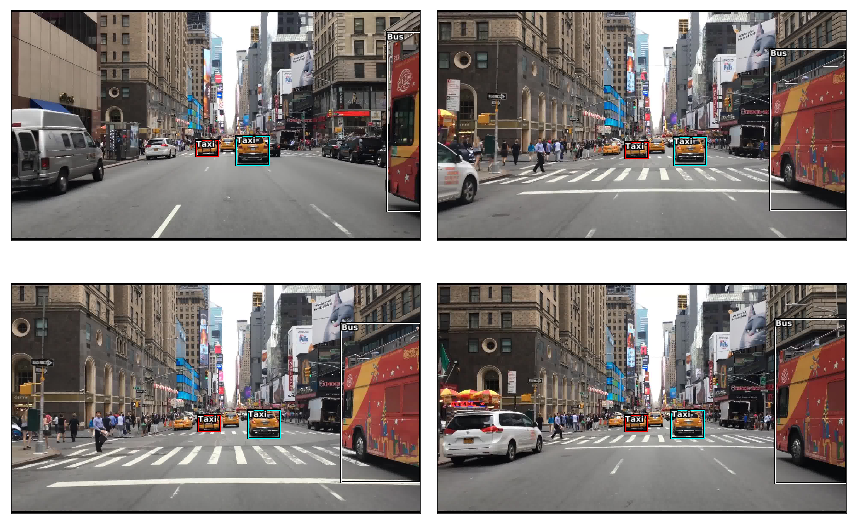

In [56]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
for i,ax in enumerate(axes.flat):
    imgidx = random.randint(0, len(images)-1)
    print("image id", imgidx)
    cs_draw_idx(imgidx, ax=ax)
plt.tight_layout()

## Part II : train a model using fastai framework

### Requirements: 
* fast.ai version 1 installed. see https://github.com/fastai/fastai/tree/master/old
* To launch an AWS instance configured for fastai, see https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md


### setup and define parameters (size, batch size, etc)

In [57]:
from fastai.conv_learner import *
from fastai.dataset import *
f_model = resnet34
sz=224
bs=64

### do we have what we need? 

In [58]:
torch.cuda.is_available()

True

In [59]:
# create tmp folder in BASE_DIR
tmp_path = BASE_DIR/'tmp'
if not os.path.exists(tmp_path):
    os.mkdir(tmp_path)

## Train an (overly) simple Fastai model
### Note that this CNN architecture has extremely simple 'head' layers, and works well when there's only a single object to detect in each frame.  

### When there are two or more objects, it picks some combination of their coordinates, that is it fails miserably.

In [60]:
# get annotation for the object requested only
def get_yxhw(img, obj_id = first_obj_id):
    return get_bb_yx_as_str(get_wh(labels_dict[img.stem][obj_id]))

def obj_exists(img, obj_id = first_obj_id):
    return obj_id in labels_dict[img.stem]

#evaluate_on_images(train_images, val_images)
def evaluate_on_images(train_images, val_images):
    useful_train_images = [img for img in train_images if obj_exists(img)]
    useful_val_images = [img for img in val_images if obj_exists(img)]
    
    train_and_val_images = useful_train_images + useful_val_images
    val_offset_idx = len(useful_train_images) 
    # get indices of all training images: offset+1,...
    val_idxs = np.array(range(len(useful_val_images))) + val_offset_idx
    
    # dump annotations into a csv file. 
    # TODO: add class column if you want to detect multiple classes
    df = pd.DataFrame({'fn': [fn.name for fn in train_and_val_images ], 
                       'bbox': [get_yxhw(img) for img in train_and_val_images]},
                       columns = ['fn', 'bbox'])
    
    bb_df = tmp_path/'train_images.csv'
    print('storing in', bb_df)
    df.to_csv(bb_df, index=False)
    
    
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(20, tfm_y=TfmType.COORD),
            RandomLighting(0.2,0.2, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs,  tfm_y=TfmType.COORD)
    md = ImageClassifierData.from_csv(FRAMES_DIR, "", bb_df, tfms=tfms, continuous=True, bs=bs,
                                      val_idxs=val_idxs)

    print("Training data: ", len(md.trn_dl.dataset.fnames))
    md.trn_dl.dataset.fnames[:5]
    print("Validation data: ", len(md.val_dl.dataset.fnames))
    md.val_dl.dataset.fnames[:5]

    
    head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
    learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
    learn.opt_fn = optim.Adam
    learn.crit = nn.L1Loss()

    # train on last layer with learning rate = 5e-3
    lr = 5e-3
    learn.freeze_to(-1)
    learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
    
    # unfreeze another layer, train with smaller learning rates for deeper layers
    learn.freeze_to(-2)
    lrs = np.array([lr/100,lr/10,lr])
    learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
    
    saved_model_name = 'clay_sciences_fastai.model'
    learn.save(saved_model_name)
    print("done - saved model in", saved_model_name)
    return bb_df, learn, md

### Train! 

In [69]:
shuffled_images = list(images) # make a copy of images
random.shuffle(shuffled_images)
# devide dataset into train and validation sets (80% training and 20% validation)
n = len(shuffled_images)
trainsize = round(n*0.8)
print(n, trainsize)
train_images = shuffled_images[:trainsize]
val_images = shuffled_images[trainsize:]
# train the model
bb_df, learn, md = evaluate_on_images(train_images, val_images)

240 192
storing in data/new/tmp/train_images.csv
Training data:  140
Validation data:  39


A Jupyter Widget

epoch      trn_loss   val_loss                         
    0      102.579447 85.042168 
    1      83.088126  60.729118                         
    2      78.536181  50.445812                         


A Jupyter Widget

epoch      trn_loss   val_loss                          
    0      61.314872  97.466728 
    1      60.568363  44.400085                         
    2      50.792708  42.390194                         
done - saved model in clay_sciences_fastai.model


#### Change this learner to be in evaluation mode - training is over, now it's eval time

In [70]:
learn.model.eval()
learn.summary()



OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

## show some images from training set
Notice the random transformations - rotation, lighting, flipping - that multiply the training data

(224, 224)  bb = [ 206.   22.   17.  171.]
(224, 224)  bb = [ 217.   40.    6.  145.]
(224, 224)  bb = [   1.   28.   28.  165.]
(224, 224)  bb = [ 183.   44.   41.  161.]
(224, 224)  bb = [   1.   38.   41.  153.]
(224, 224)  bb = [ 178.   11.   46.  163.]
(224, 224)  bb = [   0.    0.   50.  153.]
(224, 224)  bb = [   1.   37.   39.  154.]
(224, 224)  bb = [   0.   60.   51.  162.]


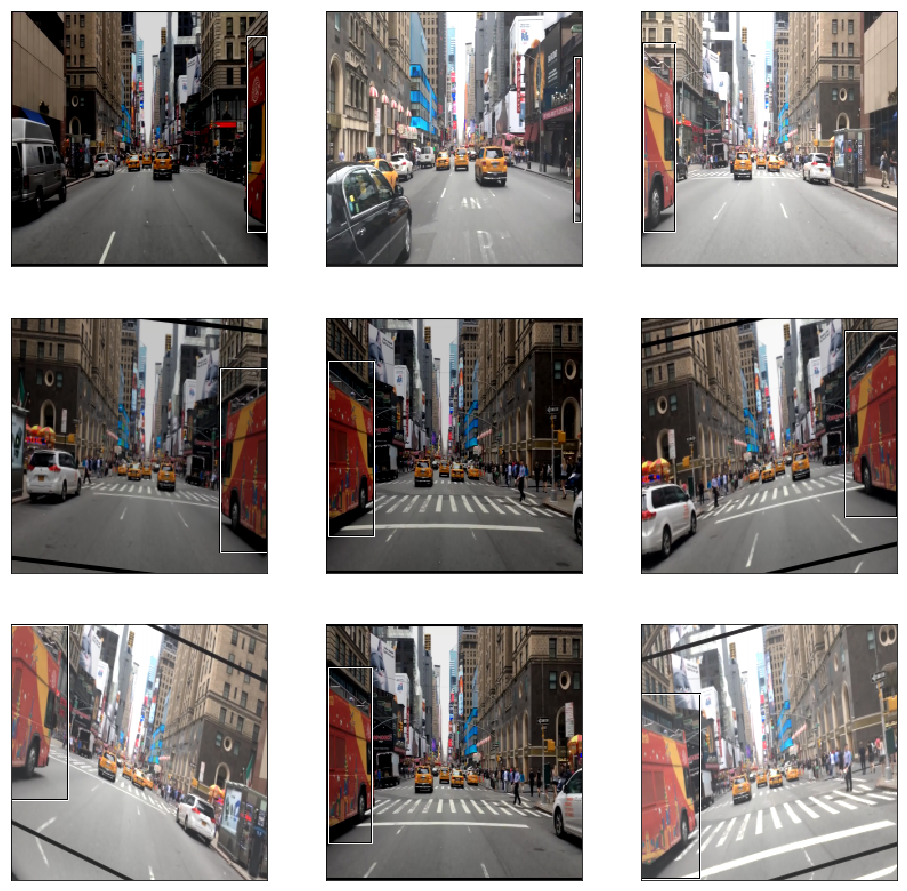

In [71]:
fig,axes = plt.subplots(3,3, figsize=(16,16))
idx=3
trn_iter = iter(md.trn_dl)
x,y = next(trn_iter)
idx = 0
for i,ax in enumerate(axes.flat):
    # get new batch
    idx = i
    if i >= len(x):
        x,y = next(trn_iter)
        idx = 0

    im = md.trn_ds.denorm(to_np(x))[idx]
    b=yxbb_2wh(y[idx])
    print("{}  bb = {}".format(im.shape[:2], b))
    cs_show_img(im, ax=ax)
    cs_draw_rect(ax,b)

### show some images from validation set and the predictions on them
#### As cautioned above, the predictions are not going to do a good job. 
The main goal of this notebook is to show how fast you can get from video annotation to deep learning. An improved deep learning model will be updated here soon.

(224, 224)  prediction = [ 192.69014   29.29325  105.14952   86.37953]
(224, 224)  prediction = [ 215.67752   29.56412  109.14694   86.66788]
(224, 224)  prediction = [ 195.97916   30.8454   109.01251   83.18507]
(224, 224)  prediction = [ 303.92792   38.79239   90.3616   139.6275 ]
(224, 224)  prediction = [ 202.32721   32.79605   67.96246   84.09097]
(224, 224)  prediction = [ 222.89297   28.95651   72.50217  165.86803]


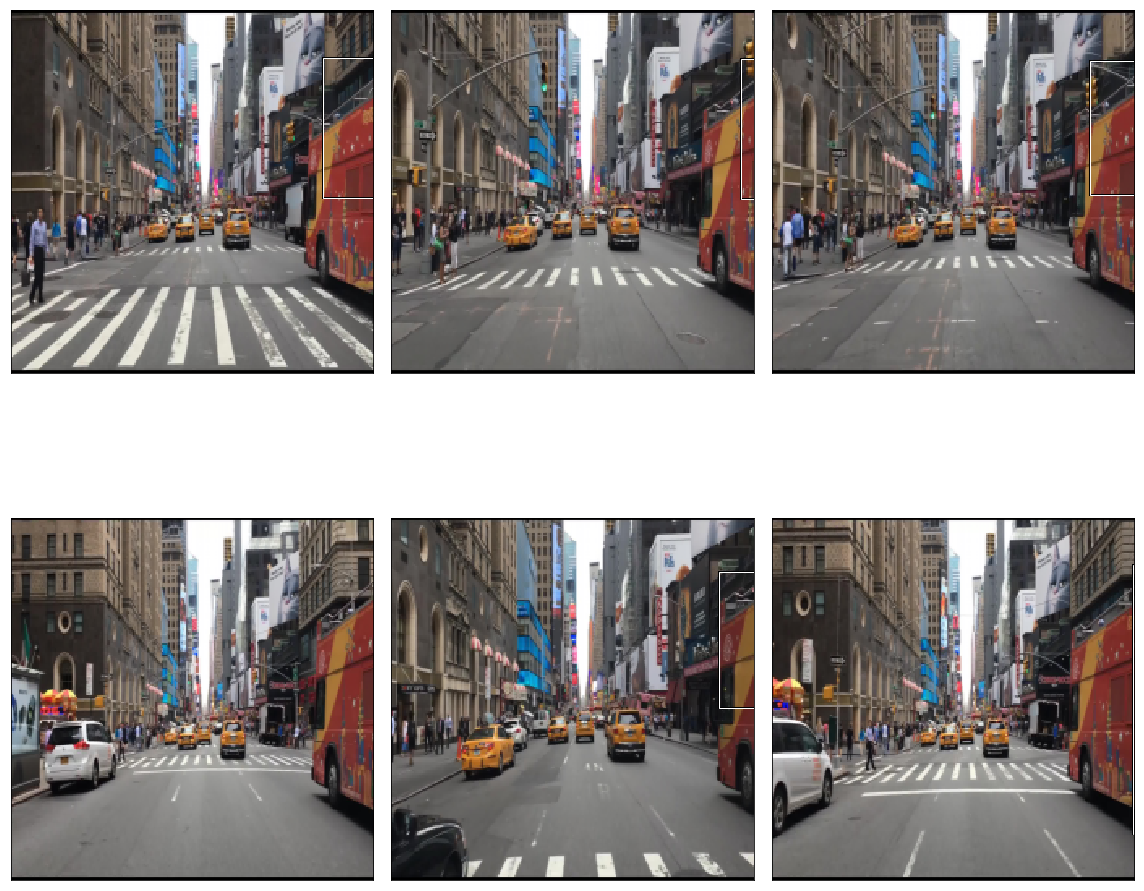

In [72]:
val_iter = iter(md.val_dl)
x,y = next(val_iter)
idx = 0
fig, axes = plt.subplots(2,3, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    idx = i
    if i >= len(x):
        x,y = next(val_iter)
        idx = 0
    preds = to_np(learn.model(VV(x)))
    im = md.val_ds.denorm(to_np(x))[idx]
    
    b = yxbb_2wh(preds[idx])
    print("{}  prediction = {}".format(im.shape[:2], b))
    cs_show_img(im, ax=ax)
    cs_draw_rect(ax,b)